# Ch4. Neural Network Learning
ニューラルネットワークの学習

---

# Loss Function
誤差関数の実装

ニューラルネットワークの学習で用いられる指標に損失関数(loss function)がある．  
損失関数は教師データに適合したデータほど小さな値を返す．

## 2乗和誤差(mean squared error)

\begin{equation}E=\frac{1}{2}\sum_{k}(y_k-t_k)^2\end{equation}
もっとも有名な損失関数  
$y_k$はニューラルネットワークの出力，$t_k$は教師データ

In [1]:
import numpy as np

def mean_squared_error(y, t):
    return 0.5 * np.sum((y - t) ** 2)

In [2]:
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]    #one-hot表現 2を表す
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]    #2の確率が最も高い場合

mean_squared_error(np.array(y), np.array(t))

0.09750000000000003

In [3]:
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]    #7の確率が最も高い場合

mean_squared_error(np.array(y), np.array(t))

0.4225

このように，2乗和誤差の小さい方が教師データに適合していることを示す．

## 交差エントロピー誤差(cross entropy error)

\begin{equation}E=-\sum_{k}t_k\log{y_k}\end{equation}

$t_k$は正解ラベル以外は0を取るので，実質正解ラベルの確率の自然対数を計算する関数である．

In [4]:
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))    #log(0)を防ぐ

In [5]:
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]    #正解は2
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]    #2の確率が最も高い場合

cross_entropy_error(np.array(y), np.array(t))

0.510825457099338

In [6]:
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]    #7の確率が最も高い場合

cross_entropy_error(np.array(y), np.array(t))

2.302584092994546

同様に値の小さい方が教師データに適合していることを示している．

---


学習フェーズではすべての訓練データについての損失関数を求める必要がある．つまり，損失関数の和を指標とする．

\begin{equation}E=-\frac{1}{N}\sum_{n}\sum_{k}t_{nk}\log{y_{nk}}\end{equation}

上記の式はN個分のデータの交差エントロピー誤差の平均を計算している．

しかし，数万個の訓練データを計算するのは膨大な時間がかかるため，ここでは100枚を無作為に選びだして学習を行う．  
この手法を**ミニバッチ学習**という．

In [7]:
import sys, os
sys.path.append('sample')    #sampleフォルダを追加
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(one_hot_label=True, normalize=True)

train_size = x_train.shape[0]    #訓練データの数
batch_size = 10    #抽出する数
batch_mask = np.random.choice(train_size, batch_size)    #10個を抽出
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

交差エントロピー誤差をバッチ対応版に再実装する

In [8]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y)) / batch_size

# Numerical Differentiation
数値微分(numerical differentiation)の実装

## 数値微分

In [9]:
def numerical_diff(f, x):
    h = 1e-4
    return (f(x + h) - f(x - h)) / (2 * h)    #中心差分

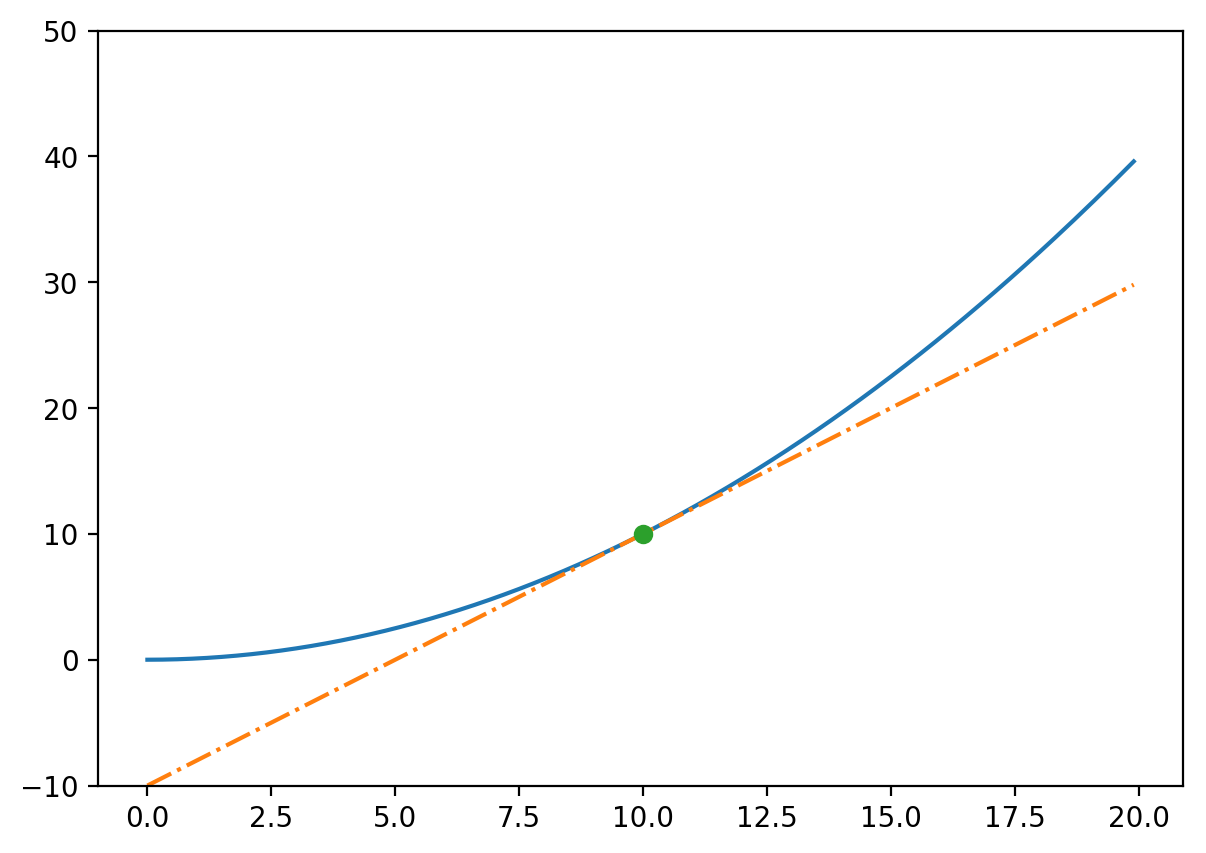

In [16]:
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

%config InlineBackend.figure_formats = {'png', 'retina'}
%matplotlib inline
plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['figure.dpi'] = 100

def function_1(x):
    return 0.1 * x ** 2

def tangent_line(f, x):
    d = numerical_diff(f, x)
    y = f(x) - d*x
    return lambda t: d * t + y    #無名関数

x = np.arange(0, 20.0, 0.1)
y = function_1(x)

def draw_diff(val=10):
    
    plt.ylim(-10, 50)
    plt.plot(x, y)
    
    tf = tangent_line(function_1, val)
    y2 = tf(x)
    
    plt.plot(x, y2, "-.")
    plt.plot(val, function_1(val), "o")
    plt.show()
    
draw_diff(10)

## 勾配(gradient)

全ての変数の偏微分のベクトル

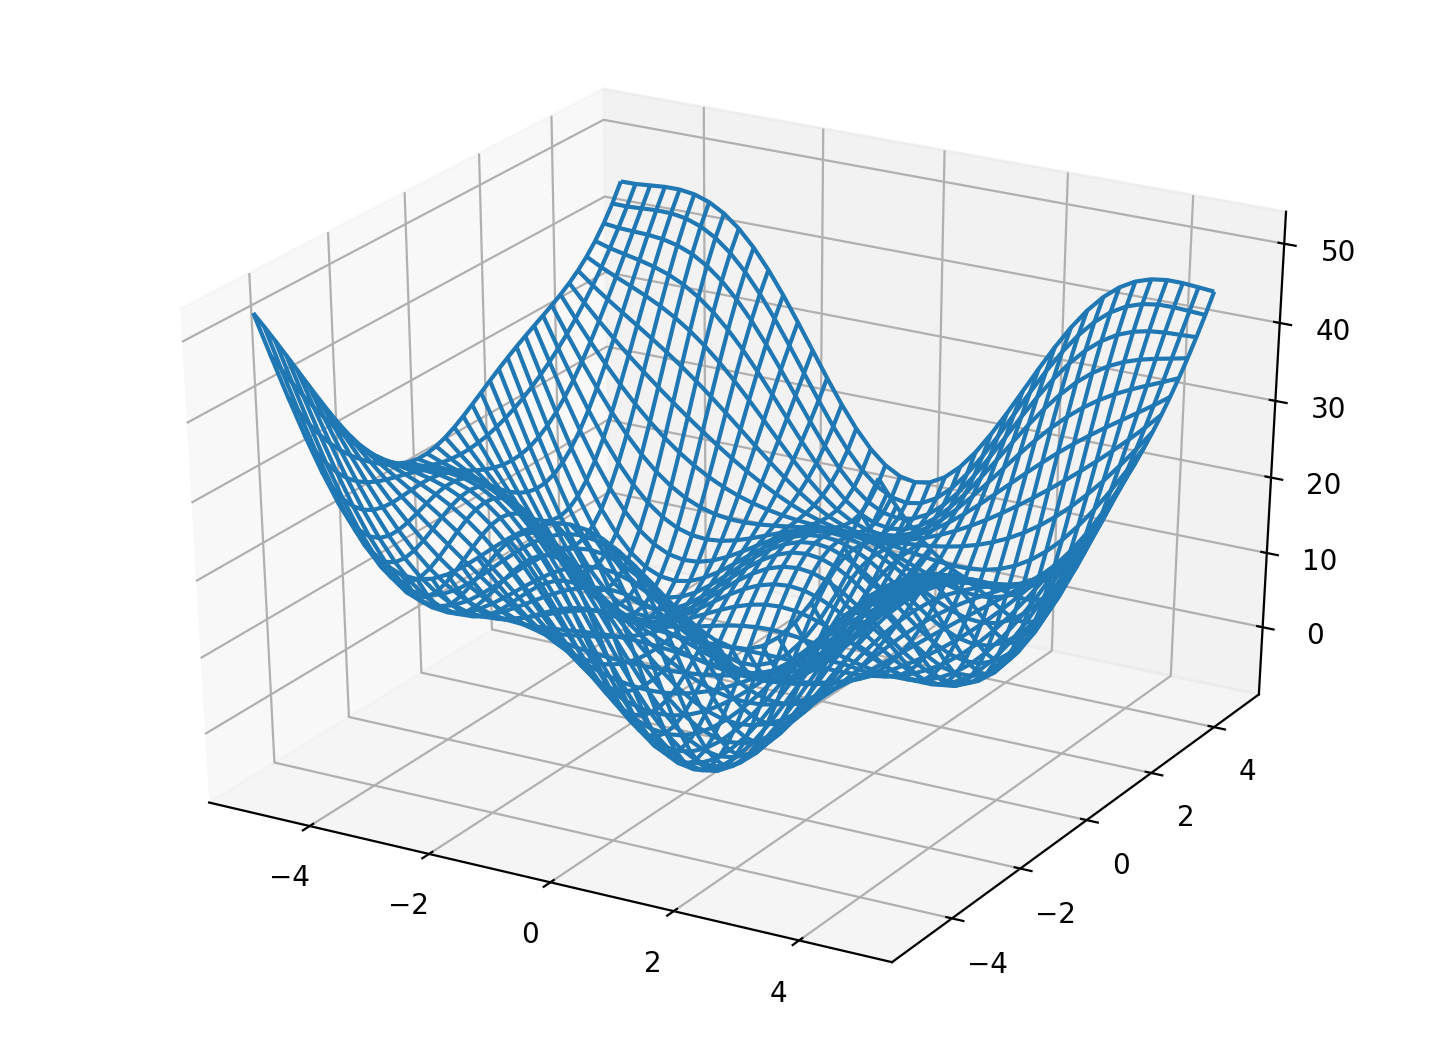

In [17]:
def function_2(x, y):
    # 適当な関数
    return x ** 2 + y ** 2 + np.cos(x) * np.sin(y) * 10
    
x = np.arange(-5, 5, 0.25)
y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(x, y)
Z = function_2(X, Y)

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_wireframe(X, Y, Z)

plt.show()

上の3次元の面に対し勾配を計算する．

In [18]:
def numerical_gradient_2d(f, x, y):
    h = 1e-4
    grad = np.zeros_like([x, y])
    grad[0] = (f(x + h, y) - f(x - h, y)) / (2 * h)
    grad[1] = (f(x, y + h) - f(x, y - h)) / (2 * h)
    
    return grad

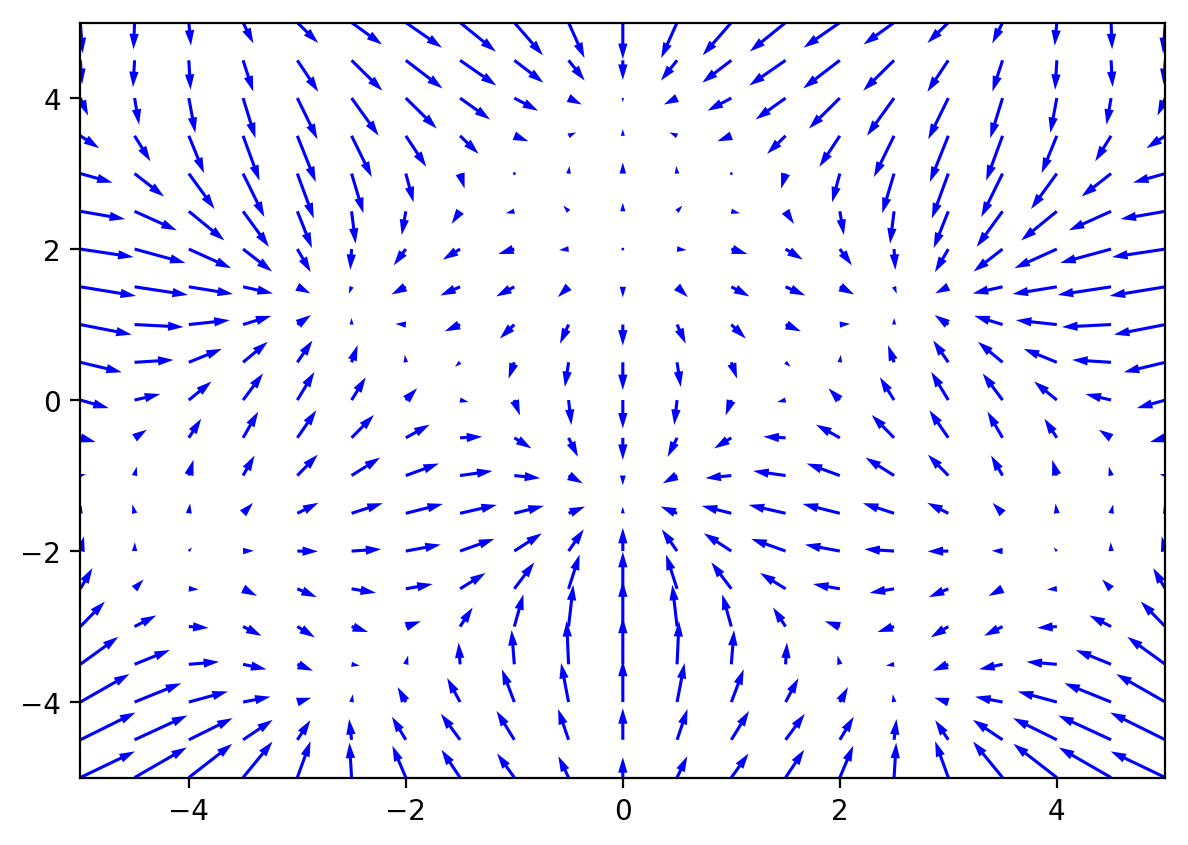

In [19]:
x = np.arange(-5, 5.5, 0.5)
y = np.arange(-5, 5.5, 0.5)
X, Y = np.meshgrid(x, y)
G = numerical_gradient_2d(function_2, X, Y)

plt.quiver(X, Y, -G[0], -G[1] ,color='b', headaxislength=5)
plt.axis([-5, 5, -5, 5])

plt.show()

勾配が面の傾きを表していることが分かる．

## 勾配降下法

勾配について，ニューラルネットワークのような多次元に対応するために再実装する．

In [20]:
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        fxh1 = f([n+h if i==idx else n for i, n in enumerate(x)])
        fxh2 = f([m-h if j==idx else m for j, m in enumerate(x)])
        grad[idx] = (fxh1 - fxh2) / (2 * h)
        
    return grad 

ニューラルネットワークでは，勾配の値が関数の値を最も減らす方向である．関数の値を徐々に減らしていく方法を**勾配降下法(gradient descent method)**という．

\begin{equation}
x_0=x_0-\eta\frac{\partial f}{\partial x_0}\\
x_1=x_1-\eta\frac{\partial f}{\partial x_1}
\end{equation}

ここで，$\eta$は更新の量である**学習率(learning late)**であり，どれだけ学習すべきか，どれだかパラメータを更新するかを表す．

勾配降下法を実装する．

In [21]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    #f:関数 init_x:初期値 lr:学習率(learning late) step_num:試行回数
    x = init_x
    
    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad
        
    return x

$f(x_0,x_1)=x_0^2+x_1^2$の最小値を勾配法で求める．

In [22]:
def function_3(x):
    return x[0] ** 2 + x[1] ** 2

init_x = np.array([-3.0, 4.0])
gradient_descent(function_3, init_x, lr=0.1, step_num=100)

array([-6.11110793e-10,  8.14814391e-10])

真の最小値は(0, 0)であるので，限りなく答えに近づいた値を求めることができたといえる．
座標の変化をプロットすると次のようになる．
<img src="image\gradient_descent.png" width="500" alt="gradient_descent" align="left"/>

学習率は適切に設定する必要がある．大きすぎると大きな値へと発散してしまい，小さすぎると実際の値に近づくことなく終了してしまう．

In [23]:
init_x = np.array([-3.0, 4.0])
gradient_descent(function_3, init_x, lr=10.0, step_num=100)

array([-2.58983747e+13, -1.29524862e+12])

In [24]:
init_x = np.array([-3.0, 4.0])
gradient_descent(function_3, init_x, lr=1e-10, step_num=100)

array([-2.99999994,  3.99999992])

## ニューラルネットワークでの実装

ニューラルネットワークに対して実際に勾配を求める実装を行う．ニューラルネットワークにおける勾配は次の式で表せる．ここでは$\bf W$が$2\times3$の重みを持つとする．

\begin{equation}
 {\bf W} = 
  \begin{pmatrix} w_{11} & w_{21} & w_{31} \\ w_{12} & w_{22} & w_{32} \end{pmatrix} \\
 \frac{\partial L}{\partial {\bf W}} = 
  \begin{pmatrix} 
   \frac{\partial L}{\partial w_{11}} & \frac{\partial L}{\partial w_{21}} & \frac{\partial L}{\partial w_{31}} \\
   \frac{\partial L}{\partial w_{12}} & \frac{\partial L}{\partial w_{22}} & \frac{\partial L}{\partial w_{32}} 
  \end{pmatrix}
\end{equation}


In [25]:
import sys
sys.path.append('sample')
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

class simpleNet:
    def __init__(self):    #コンストラクタ
        self.W = np.random.randn(2, 3) #ガウス分布による乱数で初期化
        
    def predict(self, x):    #予測
        return np.dot(x, self.W)
    
    def loss(self, x, t):    #損失関数を求める x:入力データ t:正解ラベル
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)
        return loss

In [26]:
net = simpleNet()
print(net.W)

[[-0.85713454  0.77405832  1.33554472]
 [ 3.26591626 -1.75498705 -2.87164034]]


$x$に対し，$\bf W$に基づく予測を行う．

In [27]:
x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)

[ 2.42504391 -1.11505335 -1.78314947]


正解ラベルを3つ目の要素として，損失関数を求める．

In [28]:
t = np.array([0, 0, 1])
net.loss(x, t)

4.251141482746401

勾配を求める．

In [29]:
def f(W):
    return net.loss(x, t)

dW = numerical_gradient(f, net.W)
print(dW)

[[ 0.57477666  0.01667456 -0.59145122]
 [ 0.86216499  0.02501184 -0.88717684]]


# 確率的勾配降下法(SGD)
SGDにおける学習アルゴリズムの実装

ここまでの流れ

1. Mini-Batch  
    訓練データの中からランダムに一部のデータを抽出する．
2. Gradient  
    ミニバッチの損失関数を減らすために，各重みパラメータの勾配を求める．
3. Update Parameters  
    重みパラメータを勾配方向に微小量だけ更新する．  
4. Repeat  
    1～3を繰り返す．
    
この手法を，**確率的勾配降下法 (SGD:stochastic gradient descent)** と呼ぶ．

ここでは，2層ニューラルネットワークを用いて，MNISTデータセットによる手書き数字認識プログラムを作成する．

まず，2層ニューラルネットワーククラスを構築する．

In [30]:
import numpy as np
from common.functions import *
from common.gradient import numerical_gradient

class TwoLayerNet:
    
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        #input:入力層 hidden:隠れ層 output:出力層 weight_init_std
        self.params = {}
        #W1, W2: 重み　b1, b2: バイアス (ディクショナリ型)
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)    #ガウス分布で初期化
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def predict(self, x):    #推論
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
    
    # x:画像データ, t:正解ラベル
    def loss(self, x, t):    #損失関数
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):    #認識精度
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):    #勾配
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads

次に，MNISTデータセットから一部のデータを取り出した，ミニバッチにより学習を行う．

In [31]:
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

試行回数1，バッチサイズ10で実行時間を計測する．

In [32]:
import time

# Hyper parameta
iters_num = 1    # Number of gradient update
batch_size = 10    # Choice 10 data in ramdom
learning_rate = 0.1
train_size = x_train.shape[0]

tic = time.time()
for i in range(iters_num):
    # Get minibatch
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # Gradent calculation
    grad = network.numerical_gradient(x_batch, t_batch)
    
    # Update parameters
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
        
    # Record of learning progress
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

toc = time.time()
print("実行時間: {0}秒".format(toc - tic))

実行時間: 11.3573637008667秒


これを試行回数10000回，バッチサイズ100で換算すると，  
10^5 $\times$ 11.5秒 = $\simeq$ 320時間  
これでは遅すぎるので、次でもっと良い手法を扱う。